# Contrast estimations

Based on Möller et al. IUCrJ 6, 794-803 (2019)

In [25]:
%matplotlib widget

import os, sys
import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, 'functions/')
from h5_tools import *

Save the estimations in a `.npz`? The file will be overwritten

In [26]:
save = False

### functions

In [58]:
# decay of contrast due to lower resolution; equation 13 from the paper
def beta_res(a,L,E,P):
    lam = wavelength(E)
    kappa = 2*np.pi*P*a/(lam*L)
    fun = lambda v: 2/kappa**2*(kappa-v)*(np.sin(v/2)/(v/2))**2
    outp = integrate.quad(fun,0,kappa)
        
    return np.array(outp[0]**2)

# decay of contrast due to limited coherence lengths; equation 14 from the paper
def beta_q(a,d,delLamLam,q,R,sigmah,E):
    
    # compare focus size to coherence lenght
    k = wavevector(E)
    cl = coherence_lenght(R, sigmah, E)
    if a > cl:
        etah = cl
    else:
        etah = a
    # etah = cl

    # integrals
    outp = []
    f = lambda x, z: (a-x) * (d-z) * (   np.exp( -x**2 / etah**2 - 2*np.absolute(delLamLam * q * np.sqrt(1-0.25*(q/k)**2) * x  -  delLamLam/2*q**2*z/k) ) + 
                                         np.exp( -x**2 / etah**2 - 2*np.absolute(delLamLam * q * np.sqrt(1-0.25*(q/k)**2) * x  +  delLamLam/2*q**2*z/k) )   )
    
    #beta = integrate.dblquad(f, 0, d, lambda x: 0, lambda z: a)
    #beta = integrate.dblquad(f, 0, a,  0, d)
    beta = integrate.dblquad(f, 0, d, 0, a)
    
    outp.append(2*beta[0]/(d*a)**2)
    return outp


def beta_q2(a, d, delLamLam, q, R, sigmah, E):
    
    # Calculate wavevector and coherence length
    k = wavevector(E)
    cl = coherence_lenght(R, sigmah, E)
    etah = cl

    # Define the integrand function
    def integrand(x, z):
        term1 = (a - x) * (d - z)
        exp1 = np.exp(-x**2 / etah**2 - 2 * np.abs(delLamLam * q * np.sqrt(1 - 0.25 * (q / k)**2) * x - delLamLam / 2 * q**2 * z / k))
        exp2 = np.exp(-x**2 / etah**2 - 2 * np.abs(delLamLam * q * np.sqrt(1 - 0.25 * (q / k)**2) * x + delLamLam / 2 * q**2 * z / k))
        return term1 * (exp1 + exp2)

    # Perform the double integration
    beta = integrate.dblquad(integrand, 0, d, lambda x: 0, lambda z: a)
    outp = [2 * beta[0] / (d * a)**2]
    return outp


def speckle_contrast(a, L, E, P, delLamLam, q, R, sigmah,d):
    beta = beta_res(a,L,E,P) * beta_q(a,d,delLamLam,q,R,sigmah,E)
    return beta

def wavelength(E):
    lam = 1.24/E*1e-9
    return lam

def wavevector(E):
    lam = wavelength(E)
    k = 2.*np.pi/lam
    return k

def coherence_lenght(R, sigmah, E):
    lam = wavelength(E)
    return 1./(2.) * R / sigmah * lam

### parameters

In [59]:
# constants
hbarc     = 3.2e-26  # J*m
delLamLam = 1.4e-4   # Delta E over E: pink: 1e-3, Si(111) = 1.4e-4, Si(311) = 3e-5
R         = 61.5     # source distance in m from equation 15
sigmah    = 23e-6    # rms source size in m (estimation is 11x30 um)
sigmah2    = np.sqrt(928*23*1e-12)
P         = 75e-6    # pixel size in m

# The source size (FWHM) for the 3.9 nm lattice and 1% coupling is 928 µm (horizontal) and 23 µm (vertical).

# variables
a         = 24e-6    # beam focus size in m
d         = 1.5e-3   # sample thickness in m
E         = 9        # Energy in keV
L         = 7.11     # sample-detector-distance in m

### plot as a function of q

In [60]:
q_ = np.logspace(-4,-1,100)*1e10
# q_ = np.linspace(1e-3,5e-1)*1e9
b_ = np.zeros(q_.shape)
b_2 = np.zeros(q_.shape)

for i in range(len(b_)):
    b_[i] = speckle_contrast(a, L, E, P, delLamLam, q_[i], R, sigmah, d)
    b_2[i] = speckle_contrast(a, L, E, P, delLamLam, q_[i], R, sigmah2, d)
print(sigmah, sigmah2)

2.3e-05 0.0001460958589419974


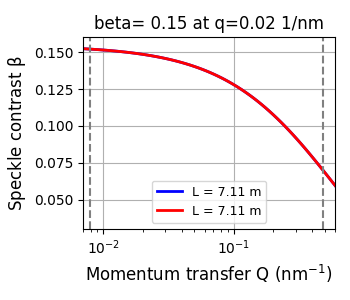

In [61]:

plt.figure(figsize=[3.5,3])

plt.plot(q_*1e-9, b_, '-',lw=2, c= 'blue',label = f'{L = } m')
plt.plot(q_*1e-9, b_2, '-',lw=2, c= 'r',label = f'{L = } m')
q_sel = 42

plt.axvline(x=0.0079, ls='--',c='gray')
plt.axvline(x=0.489, ls='--',c='gray')

plt.xscale('log')
plt.title(f'beta= {b_[q_sel]:.2f} at q={q_[q_sel]*1e-9:.2f} 1/nm')
plt.xlabel(r'Momentum transfer Q $(\rm nm^{-1})$',size=12)
plt.ylabel(r'Speckle contrast $\rm \beta$',size=12)
plt.legend(frameon=True,prop={'size': 9})
# plt.ylim(0,1)
plt.xlim(7e-3,6e-1)
plt.grid()
plt.tight_layout()
plt.show()

### plot as a function of sample-detector distance

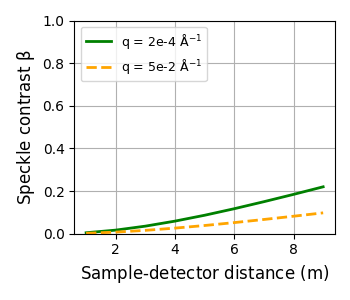

In [30]:
L_ = np.arange(1,10)
b_3 = np.zeros(L_.shape)
q = 2e-4*1e10
for i in range(len(L_)):
    b_3[i] = speckle_contrast(a, L_[i], E, P, delLamLam, q, R, sigmah,d)

L_ = np.arange(1,10)
b_4 = np.zeros(L_.shape)
q = 5e-2*1e10
for i in range(len(L_)):
    b_4[i] = speckle_contrast(a, L_[i], E, P, delLamLam, q, R, sigmah,d)
    
plt.figure(figsize=[3.5,3])
plt.plot(L_,b_3,'-',lw=2, c= 'green',label=r'q = 2e-4 $\rm \AA^{-1}$')
plt.plot(L_,b_4,'--',lw=2, c= 'orange',label=r'q = 5e-2 $\rm \AA^{-1}$')
plt.xlabel(r'Sample-detector distance $(\rm m)$',size=12)
plt.ylabel(r'Speckle contrast $\rm \beta$',size=12)
plt.legend(frameon=True,prop={'size': 9},loc='upper left')
plt.ylim(0,1)
plt.grid()
plt.tight_layout()
plt.show()

### get beta vs q for experiment

In [7]:
def find_nearest(arr, item):
    diff = np.abs(arr - item)
    ind = diff.argmin()
    return arr[ind], ind

In [8]:
runname = 'ferritin_conc_gly_50_5'
datasetnumber = 5
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

In [9]:
qv = load_data(filename, '/xpcs/g2s/q')
dq = abs(qv[0]-qv[1])
nq = len(qv)

print(f'{nq = }, {dq = :.2f}, {qv = }')

nq = 12, dq = 0.04, qv = array([0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348,
       0.388, 0.428, 0.468])


In [10]:
beta_vs_q2 = np.empty(shape=nq)
tol2 = 1e-3

for i in range(nq):
    q_min,q_min_ind = find_nearest(q_*1e-9, qv[i]-dq/2)
    q_max,q_max_ind = find_nearest(q_*1e-9, qv[i]+dq/2)
    beta_vs_q2[i] = np.mean(b_[q_min_ind:q_max_ind+1])
    
    print(f"{i}, {qv[i] = :.2f}, q = {qv[i]-dq/2:.2f} - {qv[i]+dq/2:.2f}, ind={q_min_ind}-{q_max_ind}")
    print("\t", f'{beta_vs_q2[i]:.3f}, {beta_vs_q2[i]-tol2:.4f} - {beta_vs_q2[i]+tol2:.4f}')
    print("\t", f'{np.mean(b_[q_min_ind:q_max_ind]):.4f}, {b_[q_min_ind]:.4f} - {b_[q_max_ind]:.4f}')
    print("\n")

0, qv[i] = 0.03, q = 0.01 - 0.05, ind=30-55
	 0.148, 0.1470 - 0.1490
	 0.1483, 0.1521 - 0.1413


1, qv[i] = 0.07, q = 0.05 - 0.09, ind=55-64
	 0.137, 0.1356 - 0.1376
	 0.1372, 0.1413 - 0.1311


2, qv[i] = 0.11, q = 0.09 - 0.13, ind=64-70
	 0.126, 0.1253 - 0.1273
	 0.1271, 0.1311 - 0.1210


3, qv[i] = 0.15, q = 0.13 - 0.17, ind=70-73
	 0.118, 0.1169 - 0.1189
	 0.1190, 0.1210 - 0.1148


4, qv[i] = 0.19, q = 0.17 - 0.21, ind=73-76
	 0.111, 0.1103 - 0.1123
	 0.1125, 0.1148 - 0.1077


5, qv[i] = 0.23, q = 0.21 - 0.25, ind=76-79
	 0.104, 0.1028 - 0.1048
	 0.1051, 0.1077 - 0.0998


6, qv[i] = 0.27, q = 0.25 - 0.29, ind=79-81
	 0.097, 0.0960 - 0.0980
	 0.0984, 0.0998 - 0.0941


7, qv[i] = 0.31, q = 0.29 - 0.33, ind=81-83
	 0.091, 0.0901 - 0.0921
	 0.0926, 0.0941 - 0.0881


8, qv[i] = 0.35, q = 0.33 - 0.37, ind=83-85
	 0.085, 0.0840 - 0.0860
	 0.0866, 0.0881 - 0.0818


9, qv[i] = 0.39, q = 0.37 - 0.41, ind=85-86
	 0.080, 0.0792 - 0.0812
	 0.0818, 0.0818 - 0.0786


10, qv[i] = 0.43, q = 0.41 - 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


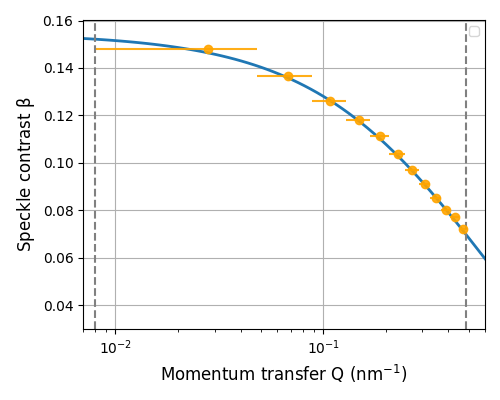

In [11]:
plt.figure(figsize=[5,4])

# -- fivos' script
plt.plot(q_*1e-9, b_, ls='-', lw=2)#, marker='o', mfc='none', c='b', label=f'{L = } m')
plt.errorbar(qv, beta_vs_q2, xerr=np.ones(nq)*dq/2,ls='', marker='o', alpha=.9, c='orange')

plt.axvline(x=qv[0]-dq/2, ls='--',c='gray')
plt.axvline(x=qv[-1]+dq/2, ls='--',c='gray')

plt.xscale('log')
plt.xlabel(r'Momentum transfer Q $(\rm nm^{-1})$',size=12)
plt.ylabel(r'Speckle contrast $\rm \beta$',size=12)
plt.legend(frameon=True,prop={'size': 9})
# plt.ylim(0.13,0.14)
plt.xlim(7e-3,6e-1)
plt.grid()
plt.tight_layout()

In [12]:
if save: np.save('../03-source/contrast_vs_q2', beta_vs_q2)

# From Anita (XFELs, Felix's paper)

In [13]:
def calculate_M_det(E,q,delLamLam,bs,L,P,d):
    """long
    """
    theta = calculate_theta(q,E)
    M_rad = calculate_M_rad(q,delLamLam,bs,E)
    M_det = np.sqrt(1+P**4*bs**2/(M_rad**2*(wavelength(E)* L)**4 )*( (bs**2)*np.cos(theta/2)**2+ (d**2)*np.sin(theta/2)**2) )

    return M_det

def calculate_M_rad(q,delLamLam,bs,E):
    """long
    """
    theta = calculate_theta(q,E)
    M_rad = np.sqrt(1+(q**2)*(delLamLam**2)/(4*(np.pi)**2)*((bs**2)*(np.cos(theta))**2 + (d**2)*(np.sin(theta))**2 ))
    return M_rad

def speckle_contrast(E,q,delLamLam,bs,L,P,d):
    """ 0.5 transv coherence
    q in nm-1
    """
    q = q*1e9
    beta = .5/(calculate_M_rad(q,delLamLam,bs,E)*calculate_M_det(E,q,delLamLam,bs,L,P,d))
    return beta

def wavelength(E):
    lam = 1.24/E*1e-9
    return lam

def calculate_theta(q,E):
    theta = np.arcsin(q/(4*np.pi/wavelength(E)))*2
    return theta

### parameters

In [14]:
bs        =  24*1e-6   # beam size in m 
d         =  1.5e-3   # sample thickness in m
E         =  9        # Energy in keV
L         =  7.11     # sample-detector-distance in m
delLamLam =  1.4e-4   # Delta E over E: pink: 2e-3, in felix paper it is fixed at 5e-3 for some reason
P         =  75e-6    # pixel size in m

In [15]:
q = np.logspace(-3,0,100)
beta = speckle_contrast(E,q,delLamLam,bs,L,P,d)
# beta

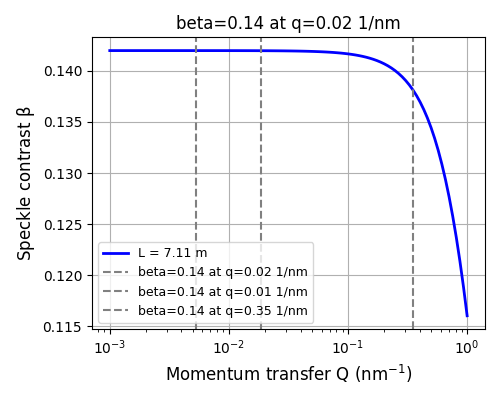

In [16]:
plt.figure(figsize=[5,4])

plt.plot(q, beta,'-',lw=2, c= 'blue',label = f'{L = } m')
q_sel, q_sel_min, q_sel_max = 42, 24, 84

plt.axvline(x=q[q_sel],ls='--',c='gray', label=f'beta={beta[q_sel]:.2f} at q={q[q_sel]:.2f} 1/nm')
plt.axvline(x=q[q_sel_min],ls='--',c='gray', label=f'beta={beta[q_sel_min]:.2f} at q={q[q_sel_min]:.2f} 1/nm')
plt.axvline(x=q[q_sel_max],ls='--',c='gray', label=f'beta={beta[q_sel_max]:.2f} at q={q[q_sel_max]:.2f} 1/nm')

plt.xscale('log')
plt.title(f'beta={beta[q_sel]:.2f} at q={q[q_sel]:.2f} 1/nm')
plt.xlabel(r'Momentum transfer Q $(\rm nm^{-1})$',size=12)
plt.ylabel(r'Speckle contrast $\rm \beta$',size=12)
plt.legend(frameon=True,prop={'size': 9})
# plt.ylim(0,1)
plt.grid()
plt.tight_layout()
plt.show()

### prepare contrast vs q list

In [18]:
runname = 'ferritin_conc_gly_50_5'
datasetnumber = 5
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

filename = h5dir + f'{runname}_{datasetnumber:04d}_filtered.h5'

In [19]:
# with h5py.File(filename, 'r') as f: 
#     f.visititems(visit_func)

In [20]:
def find_nearest(arr, item):
    diff = np.abs(arr - item)
    ind = diff.argmin()
    return arr[ind], ind

In [21]:
qv = load_data(filename, '/xpcs/g2s/q')
dq = abs(qv[0]-qv[1])
nq = len(qv)

print(f'{nq = }, {dq = :.2f}, {qv = }')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005_filtered.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [49]:
# !ls ../03-source/

In [50]:
beta_vs_q = np.empty(shape=nq)
tol = 1e-3

for i in range(nq):
    q_min,q_min_ind = find_nearest(q, qv[i]-dq/2)
    q_max,q_max_ind = find_nearest(q, qv[i]+dq/2)
    beta_vs_q[i] = np.mean(beta[q_min_ind:q_max_ind+1])
    
    print(f"{i}, {qv[i] = :.2f}, q = {qv[i]-dq/2:.2f} - {qv[i]+dq/2:.2f}, ind={q_min_ind}-{q_max_ind}")
    print("\t", f'{beta_vs_q[i]:.3f}, {beta_vs_q[i]-tol:.4f} - {beta_vs_q[i]+tol:.4f}')
    print("\t", f'{np.mean(beta[q_min_ind:q_max_ind]):.4f}, {beta[q_min_ind]:.4f} - {beta[q_max_ind]:.4f}')
    print("\n")
    
if save: np.save('../03-source/contrast_vs_q', beta_vs_q)

0, qv[i] = 0.03, q = 0.01 - 0.05, ind=30-55
	 0.142, 0.1410 - 0.1430
	 0.1420, 0.1420 - 0.1419


1, qv[i] = 0.07, q = 0.05 - 0.09, ind=55-64
	 0.142, 0.1409 - 0.1429
	 0.1419, 0.1419 - 0.1417


2, qv[i] = 0.11, q = 0.09 - 0.13, ind=64-70
	 0.142, 0.1406 - 0.1426
	 0.1416, 0.1417 - 0.1414


3, qv[i] = 0.15, q = 0.13 - 0.17, ind=70-73
	 0.141, 0.1403 - 0.1423
	 0.1413, 0.1414 - 0.1411


4, qv[i] = 0.19, q = 0.17 - 0.21, ind=73-76
	 0.141, 0.1399 - 0.1419
	 0.1410, 0.1411 - 0.1407


5, qv[i] = 0.23, q = 0.21 - 0.25, ind=76-79
	 0.140, 0.1394 - 0.1414
	 0.1405, 0.1407 - 0.1400


6, qv[i] = 0.27, q = 0.25 - 0.29, ind=79-81
	 0.140, 0.1387 - 0.1407
	 0.1399, 0.1400 - 0.1394


7, qv[i] = 0.31, q = 0.29 - 0.33, ind=81-83
	 0.139, 0.1380 - 0.1400
	 0.1392, 0.1394 - 0.1386


8, qv[i] = 0.35, q = 0.33 - 0.37, ind=83-85
	 0.138, 0.1371 - 0.1391
	 0.1384, 0.1386 - 0.1376


9, qv[i] = 0.39, q = 0.37 - 0.41, ind=85-86
	 0.137, 0.1363 - 0.1383
	 0.1376, 0.1376 - 0.1369


10, qv[i] = 0.43, q = 0.41 - 0

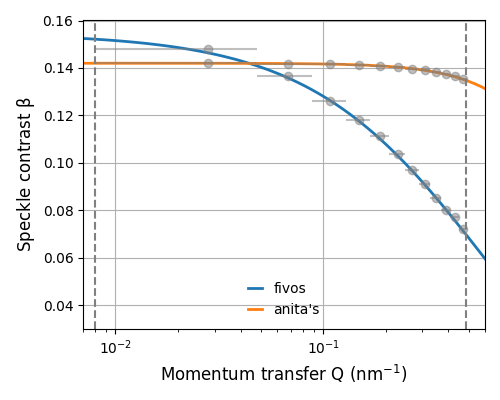

In [51]:
plt.figure(figsize=[5,4])

# -- fivos' script
plt.plot(q_*1e-9, b_, ls='-', lw=2, c='C0', label='fivos')#, marker='o', mfc='none', c='b', label=f'{L = } m')
plt.errorbar(qv, beta_vs_q2, xerr=np.ones(nq)*dq/2,ls='', marker='o', alpha=.5, c='gray')


# -- anita
plt.plot(q, beta, ls='-', lw=2, c='C1', label="anita's")#, marker='o', mfc='none', c='b', label=f'{L = } m')
plt.errorbar(qv, beta_vs_q, xerr=np.ones(nq)*dq/2,ls='', marker='o', alpha=.5, c='gray')

plt.axvline(x=qv[0]-dq/2, ls='--',c='gray')
plt.axvline(x=qv[-1]+dq/2, ls='--',c='gray')

plt.xscale('log')
plt.xlabel(r'Momentum transfer Q $(\rm nm^{-1})$',size=12)
plt.ylabel(r'Speckle contrast $\rm \beta$',size=12)
plt.legend(frameon=False, handlelength=1)
# plt.ylim(0.13,0.14)
plt.xlim(7e-3,6e-1)
plt.grid()
plt.tight_layout()

# P10

In [18]:
# constants
hbarc     = 3.2e-26  # J*m
delLamLam = 1e-4   # Delta E over E: pink: 1e-3, Si(111) = 1.4e-4, Si(311) = 3e-5
R         = 90     # source distance in m from equation 15
sigmah    = 39.5e-6    # rms source size in m (estimation is 11x30 um)
P         = 75e-6    # pixel size in m

# variables
a         = 35e-6    # beam focus size in m
d         = 1.5e-3   # sample thickness in m
E         = 12        # Energy in keV
L         = 21.2     # sample-detector-distance in m

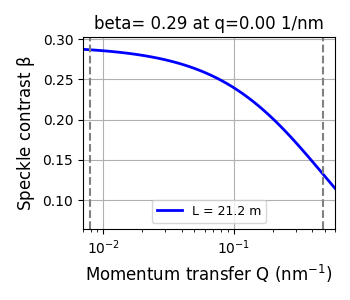

In [19]:
q_ = np.logspace(-5,-1,100)*1e10
# q_ = np.linspace(1e-3,5e-1)*1e9
b_ = np.zeros(q_.shape)

for i in range(len(b_)):
    b_[i] = speckle_contrast(a, L, E, P, delLamLam, q_[i], R, sigmah, d)

plt.figure(figsize=[3.5,3])

plt.plot(q_*1e-9,b_,'-',lw=2, c= 'blue',label = f'{L = } m')
q_sel = 42

plt.axvline(x=0.0079, ls='--',c='gray')
plt.axvline(x=0.489, ls='--',c='gray')

plt.xscale('log')
plt.title(f'beta= {b_[q_sel]:.2f} at q={q_[q_sel]*1e-9:.2f} 1/nm')
plt.xlabel(r'Momentum transfer Q $(\rm nm^{-1})$',size=12)
plt.ylabel(r'Speckle contrast $\rm \beta$',size=12)
plt.legend(frameon=True,prop={'size': 9})
# plt.ylim(0,1)
plt.xlim(7e-3,6e-1)
plt.grid()
plt.tight_layout()
# plt.show()